# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import display, Math, Latex

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,10)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Мальцев".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ L = \frac{1}{N}\sum_{i=1}^{n}\log(1 + e^{-y_{i}g(x_{i})}) + C \sum_ {j=1}^{m}\left | w_{j} \right| $$
$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$
$$ {\sigma(x)}' = \sigma(x)(1 - \sigma(x)) = \sigma(x)\sigma(-x) $$
$$ g(x_{i}) = \left \langle w, x_{i} \right \rangle $$
$$ \frac{\partial L}{\partial w_i} = \frac{1}{\sigma(y_{i}g(x_{i}))^{-1}} * {(\sigma(y_{i}g(x_{i}))^{-1})}'  + C*sign(w_{i})= \frac{1}{\sigma(y_{i}g(x_{i}))^{-1}} * \frac{-{\sigma(y_{i}g(x_{i})})'}{(\sigma(y_{i}g(x_{i}))^{2})}  + C*sign(w_{i})= \frac{1}{\sigma(y_{i}g(x_{i}))^{-1}} * \frac{-y_{i}x_{i}*\sigma(y_{i}g(x_{i}))*\sigma(-y_{i}g(x_{i}))}{(\sigma(y_{i}g(x_{i}))^{2})} = -y_{i}x_{i}\sigma(-y_{i}g(x_{i}))  + C*sign(w_{i})$$

## Имплементация (5 баллов)

In [2]:
# %%pycodestyle

from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.01, max_epoch=10, batch_size=32,
                 with_costs=False):

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        self.coef_ = None
        self.with_costs = with_costs

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def fit(self, X, y=None):
        self.coef_ = np.zeros(X.shape[1])
        return self.partial_fit(X, y)

    def logistic_func(self, theta, x):
        return float(1) / (1 + np.exp(-x.dot(theta)))

    def sgd(self, X, y, minibatch_size):
        N = y.shape[0]
        u = 0.0
        self.costs = []
        q = np.zeros(X.shape[1])
        for iter in range(self.max_epoch):
            ita = self.LearningRate(iter, N)
            #             u = u + ita * (self.C / N)
            u = u + ita * (self.C)
            X, y = shuffle(X, y)
            for i in range(0, X.shape[0], minibatch_size):
                X_mini = X[i:i + minibatch_size]
                y_mini = y[i:i + minibatch_size]
                grad_minibatch = self.get_minibatch_grad(X_mini, y_mini)
                self.coef_ -= ita * grad_minibatch
                z = np.copy(self.coef_)
                for k, el in enumerate(self.coef_):
                    if (el > 0):
                        self.coef_[k] = max(0, el - (u + q[k]))
                    elif (el < 0):
                        self.coef_[k] = min(0, el + (u - q[k]))
                q += (self.coef_ - z)
            if (self.with_costs):
                self.costs.append((self.Losses_function(X, y) +
                                   - (np.abs(self.coef_).sum() * self.C)) /
                                  X.shape[0])
        return self

    def LearningRate(self, k, N):
        return self.alpha / (1 + k)

    def Losses_function(self, X, y):
        Loss = np.sum(np.log(1 + np.exp((- X.dot(self.coef_) * y))))

        return Loss

    def get_minibatch_grad(self, X, y):
        sigm = self.sigmoid((- X.dot(self.coef_) * y))
        xiyi = X * np.tile(y.reshape(-1, 1), X.shape[1])
        grad = np.sum(-xiyi * np.tile(sigm.reshape(-1, 1), X.shape[1]), axis=0)
        return grad

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        return self.sgd(X, y, 32)

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        g = self.sigmoid(X.dot(self.coef_))
        y_hat_proba = (g, 1 - g)
        return y_hat_proba

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        g = X.dot(self.coef_)
        y_hat = np.zeros((X.shape[0],), dtype=np.float64)
        y_hat[g > 0] = 1.0
        y_hat[g < 0] = 0.0
        return y_hat

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

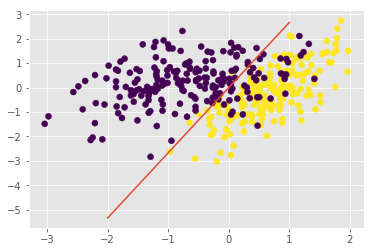

In [3]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
my_clf = MySGDClassifier(max_epoch=10)
my_clf.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y)
x = np.arange(-2, 2)
y = -1 * (x * my_clf.coef_[0]) / my_clf.coef_[1]
plt.plot(x, y)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [4]:
from sklearn.datasets import make_classification

In [5]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

Text(0.5,0,'Epoch')

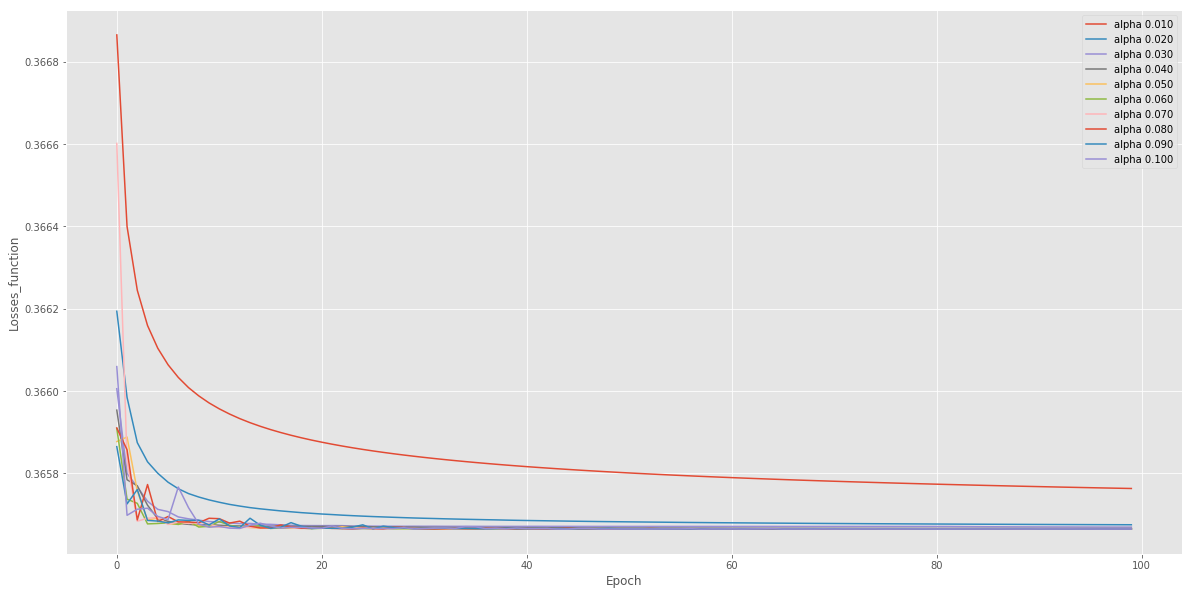

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))
for i, alpha in enumerate(np.linspace(0.01, 0.1, num=10)):
    my_clf = MySGDClassifier(max_epoch=100, alpha=alpha, with_costs=True)
    my_clf.fit(X, y)
    ax.plot(np.arange(100), my_clf.costs, label='alpha {0:.3f}'.format(alpha))
ax.legend()
ax.set_ylabel('Losses_function')
ax.set_xlabel('Epoch')

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [7]:
from sklearn.linear_model import SGDClassifier

/home/alexmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in exp


Text(0.5,0,'C')

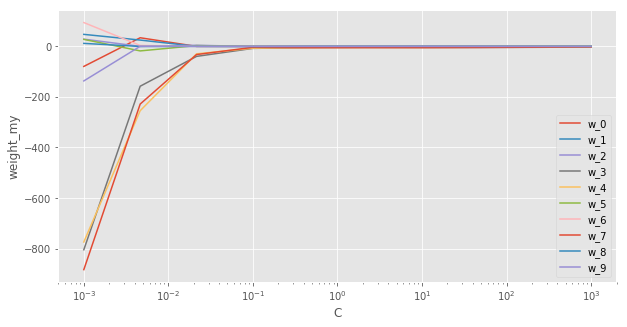

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
C = np.logspace(3, -3, 10)
Weight_my = np.zeros((X.shape[1], C.size))
for i, c in enumerate(C):
    my_clf = MySGDClassifier(C=c, alpha=1 / c)
    my_clf.fit(X, y)
    Weight_my[:, i] = my_clf.coef_
for i in range(X.shape[1]):
    ax.semilogx(C, Weight_my[i, :], label='w_{}'.format(i))
ax.legend()
ax.set_ylabel('weight_my')
ax.set_xlabel('C')

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [9]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [10]:
df_data.shape

(500000, 45)

In [11]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [12]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [13]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [14]:
print("Число уникальных карт героя у игрока: {}".format(
    df_data["player_hero_card_id"].nunique()))
print("Число уникальных карт героя у оппонента: {}".format(
    df_data["opponent_hero_card_id"].nunique()))


def one_hot(df):
    one_hot_opponent = pd.get_dummies(df["opponent_hero_card_id"],
                                      prefix="opponent_hero_card_id_",
                                      drop_first=True)
    one_hot_player = pd.get_dummies(df["player_hero_card_id"],
                                    prefix="player_hero_card_id_",
                                    drop_first=True)
    one_hot_df_data = df.join(one_hot_opponent)
    one_hot_df_data = one_hot_df_data.join(one_hot_player)
    return one_hot_df_data.drop(
        ["opponent_hero_card_id", "player_hero_card_id"], axis=1)


one_hot_df_data = one_hot(df_data)
one_hot_df_data.head().T

Число уникальных карт героя у игрока: 9
Число уникальных карт героя у оппонента: 9


gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV

In [16]:
y = one_hot_df_data['decision'].values
X = np.float64(one_hot_df_data[one_hot_df_data.columns[1:]].values)

In [17]:
model = Pipeline([
    ('sclr', StandardScaler()),
    ('clf', MySGDClassifier()),
    ])

In [31]:
parameters = {"C": np.logspace(3, -3, 10),
              'alpha': np.logspace(3, -3, 10),
              'max_epoch': [10, 20, 30]}
clf = RandomizedSearchCV(MySGDClassifier(), parameters)
clf.fit(X, y)
clf.best_params_

/home/alexmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/alexmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/alexmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/alexmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/alexmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/alexmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/alexmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/alexmal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/home/alexmal/anaconda3/

{'C': 0.021544346900318867, 'alpha': 0.1, 'max_epoch': 10}

In [18]:
model.set_params(clf__C=0.02,\
                 clf__alpha=0.1,\
                 clf__max_epoch=10)
model.fit(X, y)

Pipeline(memory=None,
     steps=[('sclr', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', MySGDClassifier(C=0.02, alpha=0.1, batch_size=32, max_epoch=10,
        with_costs=False))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


ROC-AUC: 0.763856


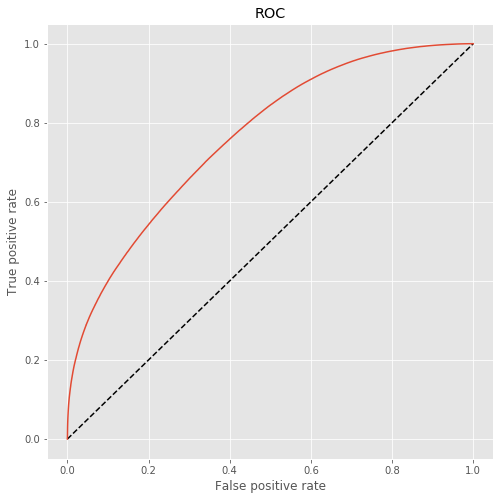

In [19]:
df_list = []
for i in range(5, 8):
    filepath = './testData_tabular_chunk%d.csv' % i
    df_list.append(pd.read_csv(filepath, sep=','))
df_test = pd.concat(df_list)
df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')
df_test = df_test.drop(['decision'], axis=1)

y_test = []
with open('./deprecated_testLabels.txt', 'r') as data:
    for val in data.read().split():
        y_test.append(int(val))

y_test = np.array(y_test)
X_test = np.float64(one_hot(df_test).values)

y_pred = model.predict_proba(X_test)[0]

print('ROC-AUC: %f' % roc_auc_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.plot(fpr, tpr)
plt.show()